**implemanting DCGAN**

# **Importing library**

In [1]:
import os
import shutil
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.optim as optim
import torch
from torchvision.utils import save_image, make_grid
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

from torchvision import transforms, datasets



# **Dataset Selection**

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ihmaidanalhaj","key":"4ee2c52d9fe156c26e530865f91f5096"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d ahmedhamada0/brain-tumor-detection
!unzip brain-tumor-detection.zip -d br35h_dataset


Dataset URL: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection
License(s): copyright-authors
  0% 0.00/84.0M [00:00<?, ?B/s]
100% 84.0M/84.0M [00:00<00:00, 1.39GB/s]
Archive:  brain-tumor-detection.zip
  inflating: br35h_dataset/Br35H-Mask-RCNN/TEST/annotations_test.json  
  inflating: br35h_dataset/Br35H-Mask-RCNN/TEST/y701.jpg  
  inflating: br35h_dataset/Br35H-Mask-RCNN/TEST/y702.jpg  
  inflating: br35h_dataset/Br35H-Mask-RCNN/TEST/y703.jpg  
  inflating: br35h_dataset/Br35H-Mask-RCNN/TEST/y704.jpg  
  inflating: br35h_dataset/Br35H-Mask-RCNN/TEST/y705.jpg  
  inflating: br35h_dataset/Br35H-Mask-RCNN/TEST/y706.jpg  
  inflating: br35h_dataset/Br35H-Mask-RCNN/TEST/y707.jpg  
  inflating: br35h_dataset/Br35H-Mask-RCNN/TEST/y708.jpg  
  inflating: br35h_dataset/Br35H-Mask-RCNN/TEST/y709.jpg  
  inflating: br35h_dataset/Br35H-Mask-RCNN/TEST/y710.jpg  
  inflating: br35h_dataset/Br35H-Mask-RCNN/TEST/y711.jpg  
  inflating: br35h_dataset/Br35H-Mask-RCNN/TEST/y712.jpg  
 

In [5]:

tumor_path = 'br35h_dataset/yes'
no_tumor_path = 'br35h_dataset/no'

tumor_count = len(os.listdir(tumor_path))
no_tumor_count = len(os.listdir(no_tumor_path))

print(f"Tumor images: {tumor_count}")
print(f"No tumor images: {no_tumor_count}")


Tumor images: 1500
No tumor images: 1500


the dataset here is balanced

# **making the dataset Imbalance for the project**

In [6]:
# Create the main directory
os.makedirs('imbalanced_data', exist_ok=True)

# Move class folders into 'imbalanced_data'
if os.path.exists('tumor'):
    shutil.move('tumor', 'imbalanced_data/tumor')

if os.path.exists('no_tumor'):
    shutil.move('no_tumor', 'imbalanced_data/no_tumor')

print("Folders moved into 'imbalanced_data' successfully.")

Folders moved into 'imbalanced_data' successfully.


In [7]:
# Ensure destination folders exist
os.makedirs('imbalanced_data/tumor', exist_ok=True)
os.makedirs('imbalanced_data/no_tumor', exist_ok=True)

# Copy 200 tumor images (minority)
tumor_images = os.listdir('br35h_dataset/yes')[:200]
for img in tumor_images:
    src = os.path.join('br35h_dataset/yes', img)
    dst = os.path.join('imbalanced_data/tumor', img)
    if os.path.isfile(src):  # Ensure it's a file, not a folder
        shutil.copyfile(src, dst)

# Copy all no_tumor images (majority)
no_tumor_images = os.listdir('br35h_dataset/no')
for img in no_tumor_images:
    src = os.path.join('br35h_dataset/no', img)
    dst = os.path.join('imbalanced_data/no_tumor', img)
    if os.path.isfile(src):
        shutil.copyfile(src, dst)

print(f"Tumor (minority) images: {len(os.listdir('imbalanced_data/tumor'))}")
print(f"No Tumor (majority) images: {len(os.listdir('imbalanced_data/no_tumor'))}")


Tumor (minority) images: 200
No Tumor (majority) images: 1500


# **visualize imbalanced classes**

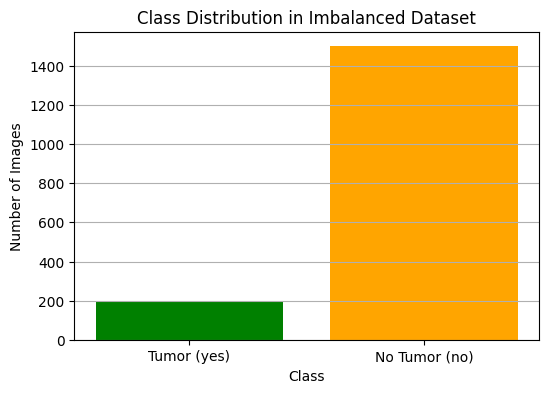

In [8]:
# Count images in each class
tumor_count = len(os.listdir('imbalanced_data/tumor'))
no_tumor_count = len(os.listdir('imbalanced_data/no_tumor'))

# Data for plotting
classes = ['Tumor (yes)', 'No Tumor (no)']
counts = [tumor_count, no_tumor_count]

# Plot
plt.figure(figsize=(6,4))
plt.bar(classes, counts, color=['green', 'orange'])
plt.title('Class Distribution in Imbalanced Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.grid(axis='y')
plt.show()


# **Define the Generator and Discriminator for DCGAN**

In [37]:
class DCGANGenerator(nn.Module):
    def __init__(self, z_dim=100):
        super(DCGANGenerator, self).__init__()
        self.net = nn.Sequential(
            # Input: (z_dim, 1, 1)
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()  # Output shape: (1, 64, 64)
        )

    def forward(self, z):
        return self.net(z.view(z.size(0), z.size(1), 1, 1))


In [38]:
class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super(DCGANDiscriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.net(img).view(-1, 1)


In [39]:
z_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make sure these are defined in previous cells
G = DCGANGenerator(z_dim).to(device)
D = DCGANDiscriminator().to(device)
loss_fn = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))


# **Train Discriminator and Generator**

In [40]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

tumor_dataset = datasets.ImageFolder(root='imbalanced_data', transform=transform)
tumor_loader = DataLoader(tumor_dataset, batch_size=64, shuffle=True)

In [41]:
# Filter out only the tumor class (assuming class index 0 is 'no_tumor' and 1 is 'tumor', or vice versa)
tumor_class_idx = tumor_dataset.class_to_idx['tumor']

# Filter dataset to keep only tumor images
tumor_only_samples = [sample for sample in tumor_dataset.samples if sample[1] == tumor_class_idx]

# Create a new dataset with only tumor samples
from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset

class FilteredImageFolder(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __getitem__(self, index):
        path, label = self.samples[index]
        img = default_loader(path)
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.samples)

tumor_only_dataset = FilteredImageFolder(tumor_only_samples, transform=transform)
tumor_only_loader = DataLoader(tumor_only_dataset, batch_size=64, shuffle=True)


In [42]:
# Assuming G, D, optimizer_G, optimizer_D, tumor_loader, and z_dim are defined earlier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCELoss()  # <-- Define criterion here

num_epochs = 500

G.train()
D.train()

for epoch in range(num_epochs):
    loop = tqdm(tumor_loader, leave=True)
    for imgs, _ in loop:
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        real_labels = torch.full((batch_size, 1), 1.0, dtype=torch.float, device=device)
        fake_labels = torch.full((batch_size, 1), 0.0, dtype=torch.float, device=device)

        # Train Discriminator
        D.zero_grad()
        output_real = D(imgs).view(-1, 1)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_images = G(noise)
        output_fake = D(fake_images.detach()).view(-1, 1)
        loss_fake = criterion(output_fake, fake_labels)

        d_loss = loss_real + loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        G.zero_grad()
        output = D(fake_images).view(-1, 1)
        g_loss = criterion(output, real_labels)
        g_loss.backward()
        optimizer_G.step()

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(d_loss=d_loss.item(), g_loss=g_loss.item())

print("Training finished.")


Epoch [500/500]: 100%|██████████| 27/27 [00:04<00:00,  6.31it/s, d_loss=0.00685, g_loss=6.97]

Training finished.


# **Generate some synthetic tumor images**

In [43]:
G.eval()  # Set generator to eval mode

num_synthetic = 50  # Number of images to generate and visualize
output_dir = "balanced_data_using_dcgan/tumor"
os.makedirs(output_dir, exist_ok=True)

synthetic_images = []

with torch.no_grad():
    for i in range(num_synthetic):
        noise = torch.randn(1, z_dim, 1, 1, device=device)  # noise vector
        fake_img = G(noise)
        # Normalize to [0,1] for saving/visualization (generator output is tanh scaled [-1,1])
        fake_img = (fake_img + 1) / 2
        synthetic_images.append(fake_img.cpu())
        # Save each synthetic image
        save_image(fake_img, os.path.join(output_dir, f"tumor_fake_{i}.png"))

print(f"Saved {num_synthetic} synthetic tumor images to '{output_dir}'")


Saved 50 synthetic tumor images to 'balanced_data_using_dcgan/tumor'


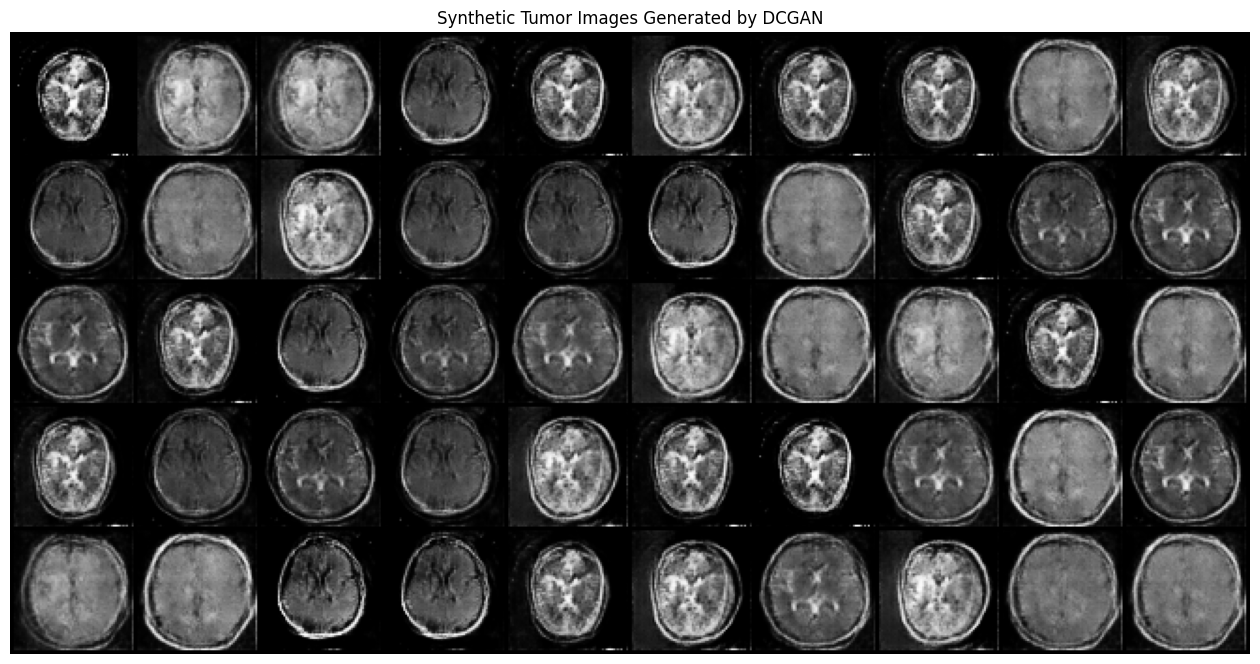

In [44]:
# Create a grid of generated images for visualization
grid = make_grid(torch.cat(synthetic_images, dim=0), nrow=10, normalize=True)

plt.figure(figsize=(16,16))
plt.imshow(grid.permute(1, 2, 0))  # CHW -> HWC for plt
plt.title("Synthetic Tumor Images Generated by DCGAN")
plt.axis('off')
plt.show()


# **Setting up the folders**

In [45]:
# Clear previous data if needed
# Remove the folder if it already exists
shutil.rmtree('balanced_data_using_DCGAN', ignore_errors=True)

# Create the class subfolders
os.makedirs('balanced_data_using_DCGAN/tumor', exist_ok=True)
os.makedirs('balanced_data_using_DCGAN/no_tumor', exist_ok=True)

#Copy all real "no_tumor" images
for img in os.listdir('imbalanced_data/no_tumor'):
    if img.lower().endswith(('.jpg', '.jpeg', '.png')):
        shutil.copy(
            os.path.join('imbalanced_data/no_tumor', img),
            os.path.join('balanced_data_using_DCGAN/no_tumor', img)
        )

#Copy ONLY 200 real tumor images
tumor_images = [img for img in os.listdir('imbalanced_data/tumor') if not img.startswith('synthetic_') and img.lower().endswith(('.jpg', '.jpeg', '.png'))]
real_tumor_images = tumor_images[:200]
for img in real_tumor_images:
    shutil.copy(
        os.path.join('imbalanced_data/tumor', img),
        os.path.join('balanced_data_using_DCGAN/tumor', img)
    )

#Count and print real class distributions (before generation)
num_real_tumor = len([f for f in os.listdir('balanced_data_using_DCGAN/tumor') if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
num_no_tumor = len([f for f in os.listdir('balanced_data_using_DCGAN/no_tumor') if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

print(f"Real Tumor Images: {num_real_tumor}")
print(f"No Tumor Images: {num_no_tumor}")
if num_real_tumor != num_no_tumor:
    print("Dataset is currently IMBALANCED.")
else:
    print("Dataset is currently BALANCED (unexpected).")


Real Tumor Images: 200
No Tumor Images: 1500
Dataset is currently IMBALANCED.


# **Balance the data with generated images**

In [46]:
#Count how many synthetic images are needed
num_no_tumor = len([f for f in os.listdir('balanced_data_using_DCGAN/no_tumor') if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
num_real_tumor = 200  # we just copied exactly 200

num_synthetic_needed = num_no_tumor - num_real_tumor
print(f"Need to generate {num_synthetic_needed} synthetic tumor images to balance the dataset.")

#Generate synthetic tumor images with DCGAN
G.eval()  # G is your trained Generator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 100  # use the same latent size as used in training

with torch.no_grad():
    for i in range(num_synthetic_needed):
        z = torch.randn(1, z_dim, 1, 1).to(device)
        fake_img = G(z).detach().cpu()
        fake_img = (fake_img + 1) / 2  # scale from [-1, 1] to [0, 1]
        save_image(fake_img, f"balanced_data_using_DCGAN/tumor/synthetic_{i}.png")

# Recount and verify balance
tumor_dir = 'balanced_data_using_DCGAN/tumor'

num_tumor = len([f for f in os.listdir(tumor_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

print(f"Tumor images after generation: {num_tumor}")
print(f"No Tumor images: {num_no_tumor}")

if num_tumor == num_no_tumor:
    print("The dataset is balanced.")
else:
    print("The dataset is still imbalanced.")

Need to generate 1300 synthetic tumor images to balance the dataset.
Tumor images after generation: 1500
No Tumor images: 1500
The dataset is balanced.


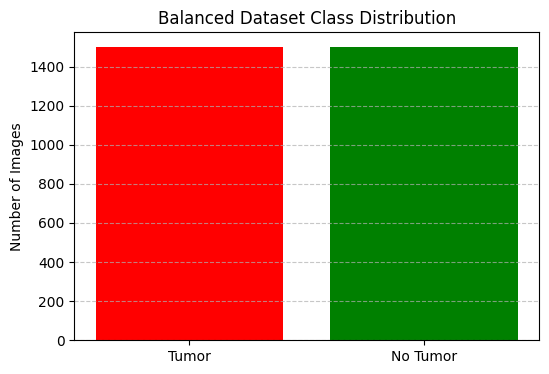

In [47]:
# Count images in each class
tumor_count = len([f for f in os.listdir('balanced_data_using_DCGAN/tumor') if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
no_tumor_count = len([f for f in os.listdir('balanced_data_using_DCGAN/no_tumor') if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Plot
plt.figure(figsize=(6, 4))
plt.bar(['Tumor', 'No Tumor'], [tumor_count, no_tumor_count], color=['red', 'green'])
plt.title("Balanced Dataset Class Distribution")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


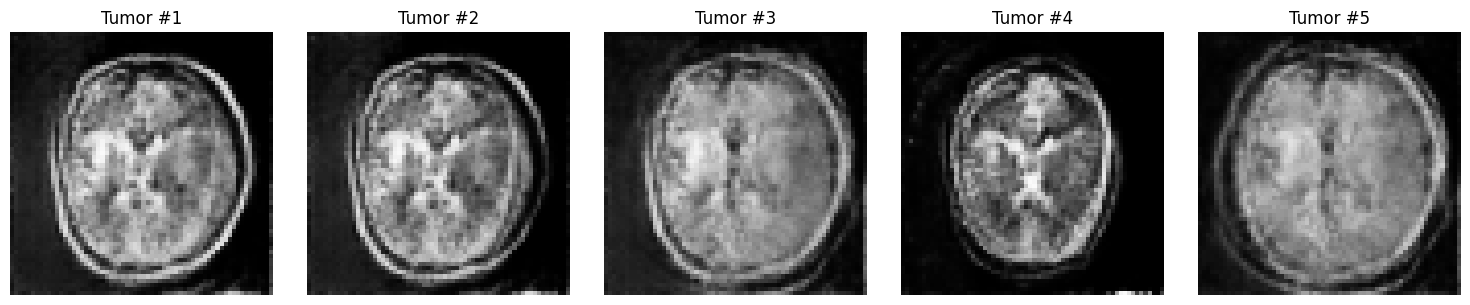

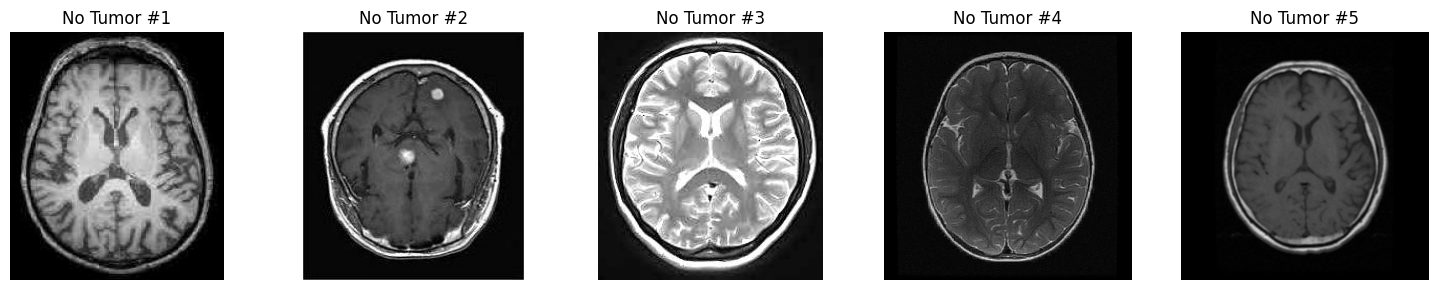

In [48]:
import random
from PIL import Image

def show_examples(class_dir, label, n=5):
    imgs = [img for img in os.listdir(class_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    selected = random.sample(imgs, n)

    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(selected):
        img = Image.open(os.path.join(class_dir, img_name))
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{label} #{i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize images
show_examples('balanced_data_using_DCGAN/tumor', 'Tumor')
show_examples('balanced_data_using_DCGAN/no_tumor', 'No Tumor')


# **Split the dataset into train and validation**

In [49]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load dataset
dataset = datasets.ImageFolder('balanced_data_using_DCGAN', transform=transform)

# Split into train and val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)


# **Define the CNN classifier**

In [50]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = CNN().to(device)


# **Train the CNN**


In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")
        evaluate(model, val_loader)

def evaluate(model, val_loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

train(model, train_loader, val_loader, epochs=10)


Epoch 1, Loss: 0.3498
Validation Accuracy: 88.50%
Epoch 2, Loss: 0.1385
Validation Accuracy: 96.33%
Epoch 3, Loss: 0.0781
Validation Accuracy: 95.50%
Epoch 4, Loss: 0.0556
Validation Accuracy: 97.67%
Epoch 5, Loss: 0.0304
Validation Accuracy: 97.00%
Epoch 6, Loss: 0.0179
Validation Accuracy: 97.17%
Epoch 7, Loss: 0.0123
Validation Accuracy: 98.00%
Epoch 8, Loss: 0.0065
Validation Accuracy: 97.50%
Epoch 9, Loss: 0.0064
Validation Accuracy: 97.33%
Epoch 10, Loss: 0.0053
Validation Accuracy: 97.50%


# **Testing and Evaluation**

In [52]:
y_true = []
y_pred = []
y_prob = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs[:, 1].cpu().numpy())  # Probability of class 'tumor'


In [53]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)
cm = confusion_matrix(y_true, y_pred)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC-ROC:   {roc_auc:.4f}")


Accuracy:  0.9750
Precision: 0.9895
Recall:    0.9592
F1 Score:  0.9741
AUC-ROC:   0.9968


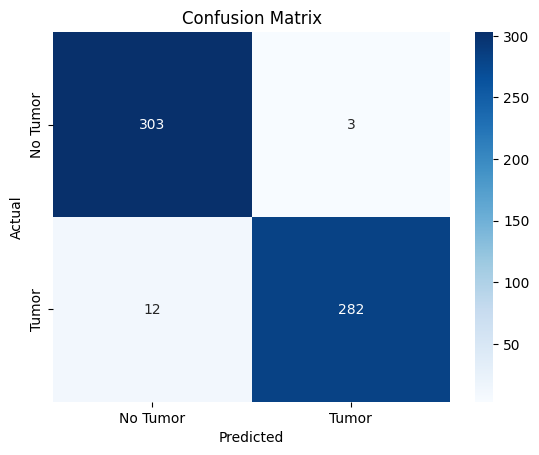

In [54]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
